In [28]:
import numpy as np
import tensorflow as tf
from scipy.integrate import solve_ivp

# Define physical parameters
m = 1.0
omega = 1.0
hbar_values_train = [5.0, 2.0, 1.0, 0.5, 0.1, 0.01]  # Values of hbar to train on
time = np.linspace(0, 10, 100)  # Time array for simulation
num_initial_conditions = 1000  # Number of random initial states for training

In [29]:
def ehrenfest_equations(t, y, hbar, m, omega):
    """Ehrenfest equations for the harmonic oscillator (expectation values)."""
    x_exp, p_exp = y
    d_x_exp_dt = p_exp / m
    d_p_exp_dt = -m * omega**2 * x_exp
    return [d_x_exp_dt, d_p_exp_dt]

training_data = []
training_labels = []

for hbar in hbar_values_train:
    for _ in range(num_initial_conditions):
        # Sample random initial conditions
        initial_x = np.random.uniform(-2, 2)
        initial_p = np.random.uniform(-2, 2)
        initial_state = [initial_x, initial_p]

        # Solve Ehrenfest equations
        solution = solve_ivp(ehrenfest_equations, (time[0], time[-1]), initial_state,
                             t_eval=time, args=(hbar, m, omega))

        # Training input: initial x, initial p, hbar
        training_data.append([initial_x, initial_p, hbar])
        # Training label: the trajectory of <x(t)> over time
        training_labels.append(solution.y[0])

training_data = np.array(training_data, dtype=np.float32)
training_labels = np.array(training_labels, dtype=np.float32)

# Reshape labels to be [num_samples, time_steps, 1] for the NN output layer
training_labels = np.expand_dims(training_labels, axis=-1)

In [30]:
def build_observable_prediction_network(time_steps):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(3,)),  # Input: initial x, p, hbar
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(time_steps)  # Output: <x(t)> at each time step
    ])
    return model

model = build_observable_prediction_network(len(time))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,476 (83.89 KB)

 Trainable params: 21,476 (83.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6562 - val_loss: 0.0063
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.4761e-04 - val_loss: 6.2733e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.2571e-04 - val_loss: 4.7145e-04
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.1158e-04 - val_loss: 3.5552e-04
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5090e-04 - val_loss: 2.7003e-04
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1774e-04 - val_loss: 2.4349e-04
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7410e-04 - val_loss: 2.1613e-04
Epoch 10/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5071e-04 - val_loss: 1.7019e-04
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3340e-04 

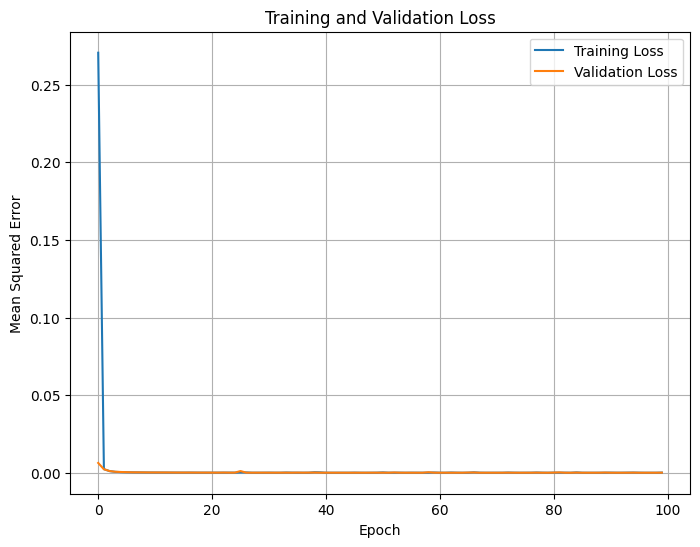

In [32]:
epochs = 100
batch_size = 32

history = model.fit(training_data, training_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Save the trained model
model.save('trained_observable_model.h5')

# Optional: Plot training history
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

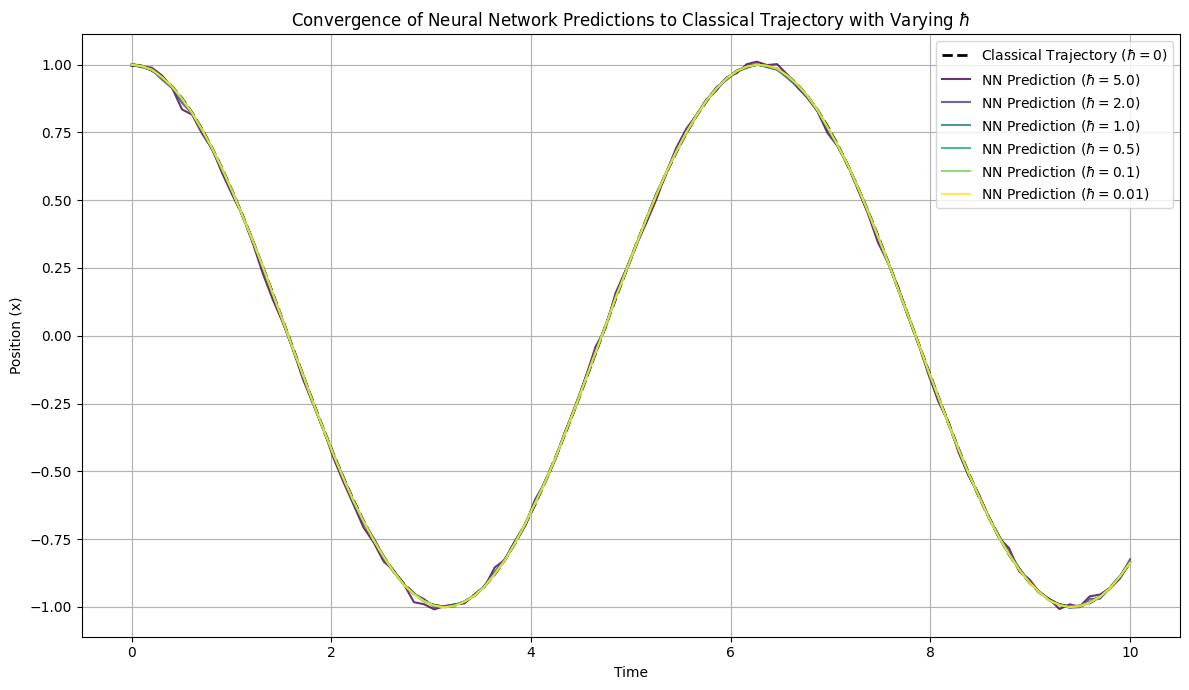

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

# (Define classical_harmonic_oscillator_evolution function as before)
classical_x = classical_harmonic_oscillator_evolution(plot_x0, plot_p0, time, m, omega)

plt.figure(figsize=(12, 7))
plt.plot(time, classical_x, label='Classical Trajectory ($\hbar = 0$)', color='black', linestyle='--', linewidth=2)

hbar_values_plot = [5.0, 2.0, 1.0, 0.5, 0.1, 0.01]
colors = plt.cm.viridis(np.linspace(0, 1, len(hbar_values_plot)))
for i, hbar in enumerate(hbar_values_plot):
    plt.plot(time, quantum_x_trajectories_nn[i], label=f'NN Prediction ($\hbar = {hbar}$)', color=colors[i], alpha=0.8)

plt.xlabel('Time')
plt.ylabel('Position (x)')
plt.title('Convergence of Neural Network Predictions to Classical Trajectory with Varying $\hbar$')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig('hbar_convergence_plot_wide_range.png')
plt.show()

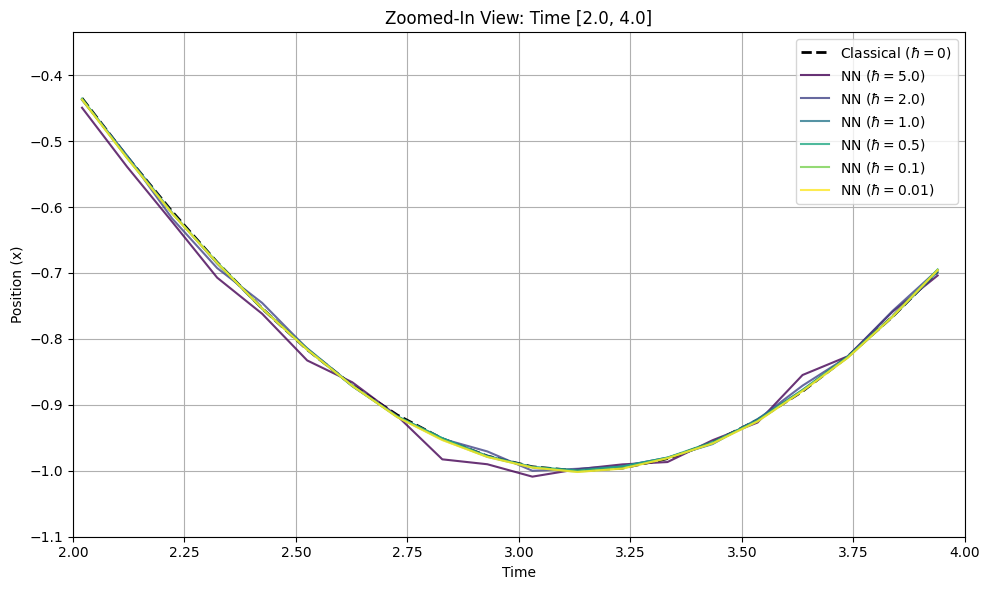

In [34]:
zoom_start = 2.0  # Time to start the zoomed-in view
zoom_end = 4.0    # Time to end the zoomed-in view
zoom_x_min = np.min(classical_x[(time >= zoom_start) & (time <= zoom_end)]) - 0.1
zoom_x_max = np.max(classical_x[(time >= zoom_start) & (time <= zoom_end)]) + 0.1

plt.figure(figsize=(10, 6))
plt.plot(time[(time >= zoom_start) & (time <= zoom_end)],
         classical_x[(time >= zoom_start) & (time <= zoom_end)],
         label='Classical ($\hbar = 0$)', color='black', linestyle='--', linewidth=2)

for i, hbar in enumerate(hbar_values_plot):
    plt.plot(time[(time >= zoom_start) & (time <= zoom_end)],
             quantum_x_trajectories_nn[i][(time >= zoom_start) & (time <= zoom_end)],
             label=f'NN ($\hbar = {hbar}$)', color=colors[i], alpha=0.8)

plt.xlabel('Time')
plt.ylabel('Position (x)')
plt.title(f'Zoomed-In View: Time [{zoom_start}, {zoom_end}]')
plt.xlim(zoom_start, zoom_end)
plt.ylim(zoom_x_min, zoom_x_max)
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig('hbar_convergence_plot_zoomed.png')
plt.show()